# BCT with mutual information and lr scheduler

In [1]:
import gc
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
import numpy as np
import torch
if not torch.cuda.is_available():
    quit()
else:
    print("Cuda capable device found!")
import matplotlib.pyplot as plt

Cuda capable device found!


# Get the datasets from memory

Assumption: dataset has its colums' names stripped from white spaces, no NaNs or +-Inf

In [2]:
ds_selector='.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT'

In [3]:
csv_files = []
for dirname, _, filenames in os.walk(ds_selector):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        csv_files.append(csv_file)
csv_files

['.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut.csv',
 '.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut_subset.csv',
 '.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut_subset_halved.csv',
 '.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\unified_jumbo.csv',
 '.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\classes\\Benign\\Benign.csv',
 '.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\classes\\ddos\\ddos.csv']

In [4]:
csv_files = ['.\\datasets\\kaggle DDoS Dataset\\CORRECT_CUT\\fair_cut_subset_halved.csv']

In [5]:
if len(csv_files) > 1:
    df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
else:
    df=pd.read_csv(csv_files[0])
    
df.columns = df.columns.str.strip()
print("Original length of df:", len(df))

Original length of df: 4000000


## Tidy up the dataset

In [7]:
#df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 80 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Src Port           int64  
 1   Dst Port           int64  
 2   Protocol           int64  
 3   Flow Duration      int64  
 4   Tot Fwd Pkts       int64  
 5   Tot Bwd Pkts       int64  
 6   TotLen Fwd Pkts    float64
 7   TotLen Bwd Pkts    float64
 8   Fwd Pkt Len Max    float64
 9   Fwd Pkt Len Min    float64
 10  Fwd Pkt Len Mean   float64
 11  Fwd Pkt Len Std    float64
 12  Bwd Pkt Len Max    float64
 13  Bwd Pkt Len Min    float64
 14  Bwd Pkt Len Mean   float64
 15  Bwd Pkt Len Std    float64
 16  Flow Byts/s        float64
 17  Flow Pkts/s        float64
 18  Flow IAT Mean      float64
 19  Flow IAT Std       float64
 20  Flow IAT Max       float64
 21  Flow IAT Min       float64
 22  Fwd IAT Tot        float64
 23  Fwd IAT Mean       float64
 24  Fwd IAT Std        float64
 25  Fwd IAT Max       

In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("After dropping NaNs, the length of df:", len(df))

After dropping NaNs, the length of df: 4000000


In [9]:
#df_copy=df.copy()

df.Label.value_counts()

Benign    2000000
ddos      2000000
Name: Label, dtype: int64

C:\Users\MAX\AppData\Local\Temp\ipykernel_8240\3788501913.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat=df_copy.corr()


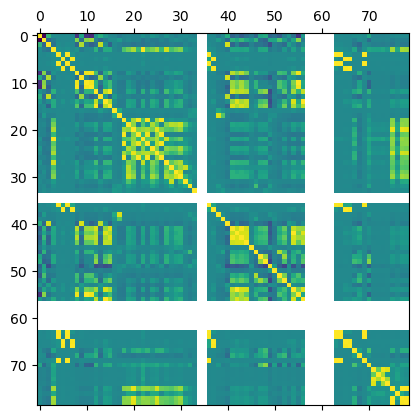

In [14]:
corr_mat=df.corr()
plt.matshow(corr_mat)
plt.show()

## Getting ready for learning

In [10]:
cols=df.columns.to_list()
#cols.sort()
cols

['Src Port',
 'Dst Port',
 'Protocol',
 'Flow Duration',
 'Tot Fwd Pkts',
 'Tot Bwd Pkts',
 'TotLen Fwd Pkts',
 'TotLen Bwd Pkts',
 'Fwd Pkt Len Max',
 'Fwd Pkt Len Min',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Bwd Pkt Len Max',
 'Bwd Pkt Len Min',
 'Bwd Pkt Len Mean',
 'Bwd Pkt Len Std',
 'Flow Byts/s',
 'Flow Pkts/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Tot',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Tot',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Len',
 'Bwd Header Len',
 'Fwd Pkts/s',
 'Bwd Pkts/s',
 'Pkt Len Min',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt',
 'Down/Up Ratio',
 'Pkt Size Avg',
 'Fwd Seg Size Avg',
 'Bwd Seg Size Avg',
 'Fwd By

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

f:\miniconda\envs\dl\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
df.drop(['Protocol'], axis=1)
#df.drop(['Unnamed: 0','Timestamp','Protocol','Flow ID','Src IP','Dst IP'], axis=1, inplace=True)

,Src Port,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,51263,443,105120546,16,24,1789.0,3492.0,270.0,0.0,111.812500,...,20,137708.714286,11188.587008,158091.0,126951.0,1.486128e+07,31810.084689,14914967.0,14824695.0,Benign
1,65507,53,599,1,1,30.0,94.0,30.0,30.0,30.000000,...,8,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,Benign
2,53552,443,131782,5,7,334.0,3776.0,208.0,0.0,66.800000,...,0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,Benign
3,443,57803,3,1,1,0.0,31.0,0.0,0.0,0.000000,...,0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,Benign
4,39733,80,8864563,13,16,333.0,19111.0,333.0,0.0,25.615385,...,0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,80,54296,37757,0,2,0.0,0.0,0.0,0.0,0.000000,...,0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,ddos
3999996,80,33246,28356,0,2,0.0,0.0,0.0,0.0,0.000000,...,0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,ddos
3999997,80,38806,40263,0,2,0.0,0.0,0.0,0.0,0.000000,...,0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,ddos
3999998,80,38796,273,0,2,0.0,0.0,0.0,0.0,0.000000,...,0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,ddos


In [8]:
cols=df.columns.to_list()
len(cols)

80

In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

X=df.drop(['Label'], axis=1)
Y=df['Label']

del df
gc.collect()

fvalue_Best = SelectKBest(mutual_info_classif, k=20)
X_kbest = fvalue_Best.fit_transform(X, Y)
mask=fvalue_Best.get_support()

print('Remaining columns:')
for m,c in zip(mask, cols):
    if m:
        print(c)

X=X_kbest

Remaining columns:
Dst Port
Protocol
TotLen Fwd Pkts
TotLen Bwd Pkts
Fwd Pkt Len Max
Fwd Pkt Len Mean
Fwd Pkt Len Std
Bwd Pkt Len Max
Fwd Header Len
Bwd Header Len
Pkt Len Max
Pkt Len Mean
Pkt Len Std
Pkt Len Var
Pkt Size Avg
Fwd Seg Size Avg
Subflow Fwd Byts
Subflow Bwd Byts
Init Bwd Win Byts
Fwd Seg Size Min


In [ ]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, Y, shuffle=True, train_size=0.75)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, shuffle=True, train_size=0.75)

del X,Y
gc.collect()

trainY=pd.Series(trainY)
valY=pd.Series(valY)

In [22]:
from torch import tensor
from torch.utils.data import Dataset, DataLoader

class NetMetrics(Dataset):
    def __init__(self, X, y, onehot):
        self.x, self.y, self.onehot = X, y, onehot
        self.len=self.x.shape[0]

    def __getitem__(self,index):
        tensor_label=self.onehot[self.y.iloc[index]]
        return tensor(self.x[index], dtype=torch.float32), tensor_label
        
    def __len__(self):
        return self.len

dict_={'ddos' : torch.tensor([1,0], dtype=torch.float32),'Benign': torch.tensor([0,1],dtype=torch.float32)}
ds=NetMetrics(scaler.fit_transform(trainX), trainY, dict_)

In [13]:
scaler2=scaler
%store scaler2

Stored 'scaler2' (StandardScaler)


## The model

In [23]:
class AttackNet(torch.nn.Module):

    def __init__(self):
        super(AttackNet, self).__init__()
        self.model=torch.nn.Sequential(
            torch.nn.Linear(20, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Tanh(),
            torch.nn.Linear(128, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 2),
            torch.nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        return self.model(x)

def init_weights(module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.0001)


model = AttackNet()
model.apply(init_weights)

AttackNet(
  (model): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=2, bias=True)
    (9): LogSoftmax(dim=1)
  )
)

## Training

In [15]:
device = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device

'cuda:0'

In [24]:
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

epochs=50
learning_rate = .001
model=model.to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
loader = DataLoader(dataset=ds, batch_size=100, shuffle=True)

# Early stopping
last_loss = np.inf
patience = 2
trigger_times = 0

In [25]:
#from torchmetrics.classification import BinaryF1Score

def model_validation(criterion):

    #val_tar=[]
    #val_pred=[]
    cumulative_L_val=0.

    val_ds = NetMetrics(scaler.transform(testX), testY, dict_)
    val_loader=DataLoader(val_ds, batch_size=100, shuffle=False)

    model.eval()

    with torch.no_grad():
        for inputs, ground_truth in val_loader:
            y_tilde = model(inputs.to(device))
            y=ground_truth

            loss_val=criterion(y_tilde, y.to(device))
            cumulative_L_val+=loss_val.item()
           
            #val_tar.append(y)
            #val_pred.append(y_tilde.clone().detach())
    
        #f1=BinaryF1Score()
        #f1_val=f1(tensor(val_pred), tensor(val_tar))

        #print('F1-score Val: ', f1_val)
    
    #return f1_val
    return cumulative_L_val
    

In [26]:
def model_train(epoch, optimizer, model):
    model.train()
    
    print("Epoch begin: ", epoch)
    cumulative_L_train = 0.
    for x,y in loader:
        # reset optimizer
        opt.zero_grad()
        loss = criterion(model(x.to(device)), y.to(device))
        loss.backward()
        opt.step()
        cumulative_L_train+=loss.item()

    return cumulative_L_train

In [27]:
#out=[]
for epoch in range(epochs):

    
    loss_train=model_train(epoch, opt, model)
    writer.add_scalar("Loss/Train", loss_train , epoch)
    
    loss_val=model_validation(criterion)
    scheduler.step()

    writer.add_scalar("Loss/Val", loss_val , epoch)

    writer.add_scalars("Loss/General", {"Train": loss_val, "Val": loss_train}, epoch)

    #EarlyStopping
    if loss_val > last_loss:
        trigger_times += 1
        print('No improvement detected')

    if trigger_times >= patience:
        print('Early stopping triggered')
        continue #exit now
    else:
        trigger_times = 0

    last_loss = loss_val

    #out.append(cumulative_L)

writer.close()

#plt.plot(out)

Epoch begin:  0
Epoch begin:  1
No improvement detected
Epoch begin:  2
Epoch begin:  3
Epoch begin:  4
No improvement detected
Epoch begin:  5
Epoch begin:  6
No improvement detected
Epoch begin:  7
No improvement detected
Epoch begin:  8
No improvement detected
Epoch begin:  9
No improvement detected
Epoch begin:  10
Epoch begin:  11
No improvement detected
Epoch begin:  12
Epoch begin:  13
No improvement detected
Epoch begin:  14
Epoch begin:  15
No improvement detected
Epoch begin:  16
Epoch begin:  17
No improvement detected
Epoch begin:  18
Epoch begin:  19
Epoch begin:  20
Epoch begin:  21
No improvement detected
Epoch begin:  22
Epoch begin:  23
No improvement detected
Epoch begin:  24
No improvement detected
Epoch begin:  25
Epoch begin:  26
Epoch begin:  27
No improvement detected
Epoch begin:  28
Epoch begin:  29
No improvement detected
Epoch begin:  30
Epoch begin:  31
Epoch begin:  32
Epoch begin:  33
Epoch begin:  34
Epoch begin:  35
No improvement detected
Epoch begin:  

In [28]:
from datetime import datetime
model_name='.\\models\\' + datetime.now().strftime("%m-%d-%Y_%H-%M-%S")+'__mi_binary_opt_sched_on_fair2M.model'
torch.save(model.state_dict(), model_name)

## Test

In [29]:
test_ds = NetMetrics(scaler.transform(testX), testY, dict_)
print(len(test_ds))
test_loader=DataLoader(test_ds, batch_size=100, shuffle=False)

1000000


In [30]:
model=AttackNet()
model.load_state_dict(torch.load('.\\models\\02-05-2023_20-49-03__mi_binary_opt_sched.model'))
model=model.to('cpu')
model.eval()

acc = [0]*2
translator={0 : 'ddos', 1 : 'Benign'}
targets=[]
preds=[]

model.eval()

with torch.no_grad():
    for inputs, ground_truth in test_loader:
        prediction = torch.argmax(model(inputs), dim=1)
        targ = torch.argmax(ground_truth, dim=1)

        targets.extend(targ.tolist())
        preds.extend(prediction.clone().detach().tolist())

    for p,t in zip(preds, targets):
        if p == t:
            acc[p]+=1

acc

[179936, 431432]

In [31]:
val_count_test=testY.value_counts()
val_count_test

ddos      500395
Benign    499605
Name: Label, dtype: int64

In [32]:
acc_final=[a/val_count_test[translator[idx]] for idx,a in enumerate(acc)]
print('Per class accuracy: ', acc_final)

Per class accuracy:  [0.35958792553882435, 0.8635462014991844]


Precision:  tensor(0.5738)
Recall:  tensor(0.8635)
F1-score:  tensor(0.6895)
Overall Accuracy:  tensor(0.6114)


<AxesSubplot: >

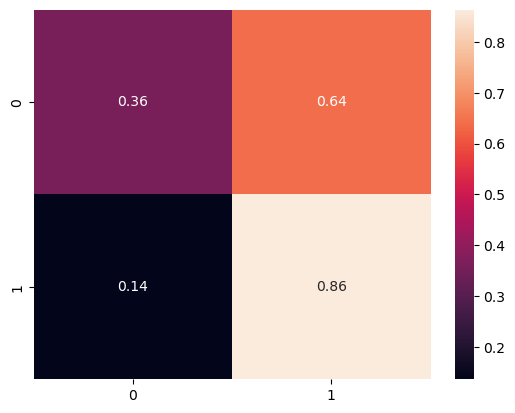

In [33]:
from torchmetrics.classification import BinaryConfusionMatrix, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAccuracy

target = torch.tensor(targets)
preds = torch.tensor(preds)
metric = BinaryConfusionMatrix(normalize='true')
res=metric(preds, target)

prec = BinaryPrecision()
print('Precision: ',prec(preds, target))

rec=BinaryRecall()
print('Recall: ', rec(preds, target))

f1=BinaryF1Score()
print('F1-score: ', f1(preds, target))

acc2=BinaryAccuracy()
print('Overall Accuracy: ', acc2(preds, target))

import seaborn as sn
sn.heatmap(res, annot=True)

___